In [19]:
import csv
import math
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

def read_csv(file_name):
    return pd.read_csv(file_name)

def calculate_distance_with_uncertainty(photon_count, ref_photon_count, ref_distance, ref_distance_uncertainty):
    distance = ref_distance * math.sqrt(ref_photon_count / photon_count)
    distance_uncertainty = abs(distance * ref_distance_uncertainty / ref_distance)
    return distance, distance_uncertainty


def find_closest_galaxy(xray_flash, galaxies, min_distance):
    closest_galaxy = None
    closest_distance = float('inf')

    for _, galaxy in galaxies.iterrows():
        distance = math.sqrt((xray_flash['Polar'] - galaxy['Polar'])**2 + (xray_flash['Equat'] - galaxy['Equat'])**2)
        if distance < closest_distance and distance < min_distance:
            closest_distance = distance
            closest_galaxy = galaxy

    return closest_galaxy


In [20]:
xray_data = read_csv('/Users/kobibrown/Desktop/Distance_Ladder_Project/Converted_Flash_Data.csv')
galaxy_data = read_csv('/Users/kobibrown/Desktop/Distance_Ladder_Project/Converted_Distant_Galaxy_Data.csv')

xray_flash1 = {'PhotonCount': 97015393, 'Distance': 752, 'DistanceUncertainty': 20}
xray_flash2 = {'PhotonCount': 25440942, 'Distance': 1397, 'DistanceUncertainty': 30}

In [22]:
distances = []
distance_uncertainties = []
radial_velocities = []
xray_galaxy_matches = []

for _, xray_flash in xray_data.iterrows():
    distance1, distance1_uncertainty = calculate_distance(xray_flash['Photon-Count'], xray_flash1['PhotonCount'], xray_flash1['Distance'], xray_flash1['DistanceUncertainty'])
    distance2, distance2_uncertainty = calculate_distance(xray_flash['Photon-Count'], xray_flash2['PhotonCount'], xray_flash2['Distance'], xray_flash2['DistanceUncertainty'])
    avg_distance = (distance1 + distance2) / 2
    avg_distance_uncertainty = (distance1_uncertainty + distance2_uncertainty) / 2
    min_distance = 0.1
    closest_galaxy = find_closest_galaxy(xray_flash, galaxy_data, min_distance)

    if closest_galaxy is not None:
        distances.append(avg_distance)
        distance_uncertainties.append(avg_distance_uncertainty)
        radial_velocities.append(closest_galaxy['RadialVelocity'])
        xray_galaxy_matches.append((xray_flash, closest_galaxy))

In [24]:
# Create a list to store matches
match_info = []

# Iterate over each x-ray flash and its closest galaxy
for (flash, galaxy) in xray_galaxy_matches:
    # Calculate the distance to the x-ray flash and the closest galaxy in Mpc
    flash_distance1, flash_distance1_uncertainty = calculate_distance_with_uncertainty(
        flash['Photon-Count'], xray_flash1['PhotonCount'], xray_flash1['Distance'], xray_flash1['DistanceUncertainty'])
    flash_distance2, flash_distance2_uncertainty = calculate_distance_with_uncertainty(
        flash['Photon-Count'], xray_flash2['PhotonCount'], xray_flash2['Distance'], xray_flash2['DistanceUncertainty'])
    flash_distance = (flash_distance1 + flash_distance2) / 2
    flash_distance_uncertainty = (flash_distance1_uncertainty + flash_distance2_uncertainty) / 2
    
    galaxy_distance = math.sqrt((flash['Polar'] - galaxy['Polar'])**2 + (flash['Equat'] - galaxy['Equat'])**2)

    # Convert the galaxy distance to equatorial distance in Mpc
    galaxy_distance_eq = galaxy_distance * math.cos(math.radians(galaxy['Polar']))

    # Add the information for this match to the list of dictionaries
    match_info.append({
        'Flash_Name': flash['Name'],
        'distance(Mpc)': flash_distance / 1e6,
        'Distance_Uncertainty(Mpc)': flash_distance_uncertainty / 1e6,
        'Galaxy Name': galaxy['Name'],
        'Distance_to_closest_galaxy': galaxy_distance_eq,
        'Galaxy_Radial_Velocity': galaxy['RadialVelocity']
    })

# Convert the list to a pandas DataFrame and print it
match_df = pd.DataFrame(match_info)
print(match_df)


   Flash_Name  distance(Mpc)  Distance_Uncertainty(Mpc)   Galaxy Name  \
0        FE01       0.220001                   0.005302     TopDG1351   
1        FE02       0.289065                   0.006966   RightDG0125   
2        FE03       0.340667                   0.008210   FrontDG0931   
3        FE04       0.444768                   0.010718   FrontDG1394   
4        FE05       0.263004                   0.006338    BackDG0044   
5        FE06       0.365000                   0.008796    BackDG0693   
6        FE07       0.168472                   0.004060  BottomDG1337   
7        FE09       0.190903                   0.004601  BottomDG0379   
8        FE10       0.407174                   0.009813     TopDG1460   
9        FE12       0.305381                   0.007359    LeftDG0394   
10       FE13       0.378259                   0.009116  BottomDG0230   
11       FE14       0.244725                   0.005898   RightDG0664   
12       FE16       0.239036                   0.00

In [25]:
# Save the match DataFrame to a new CSV file
output_file = '/Users/kobibrown/Desktop/Distance_Ladder_Project/Xray_Flash_Galaxy_Matches.csv'
match_df.to_csv(output_file, index=False)

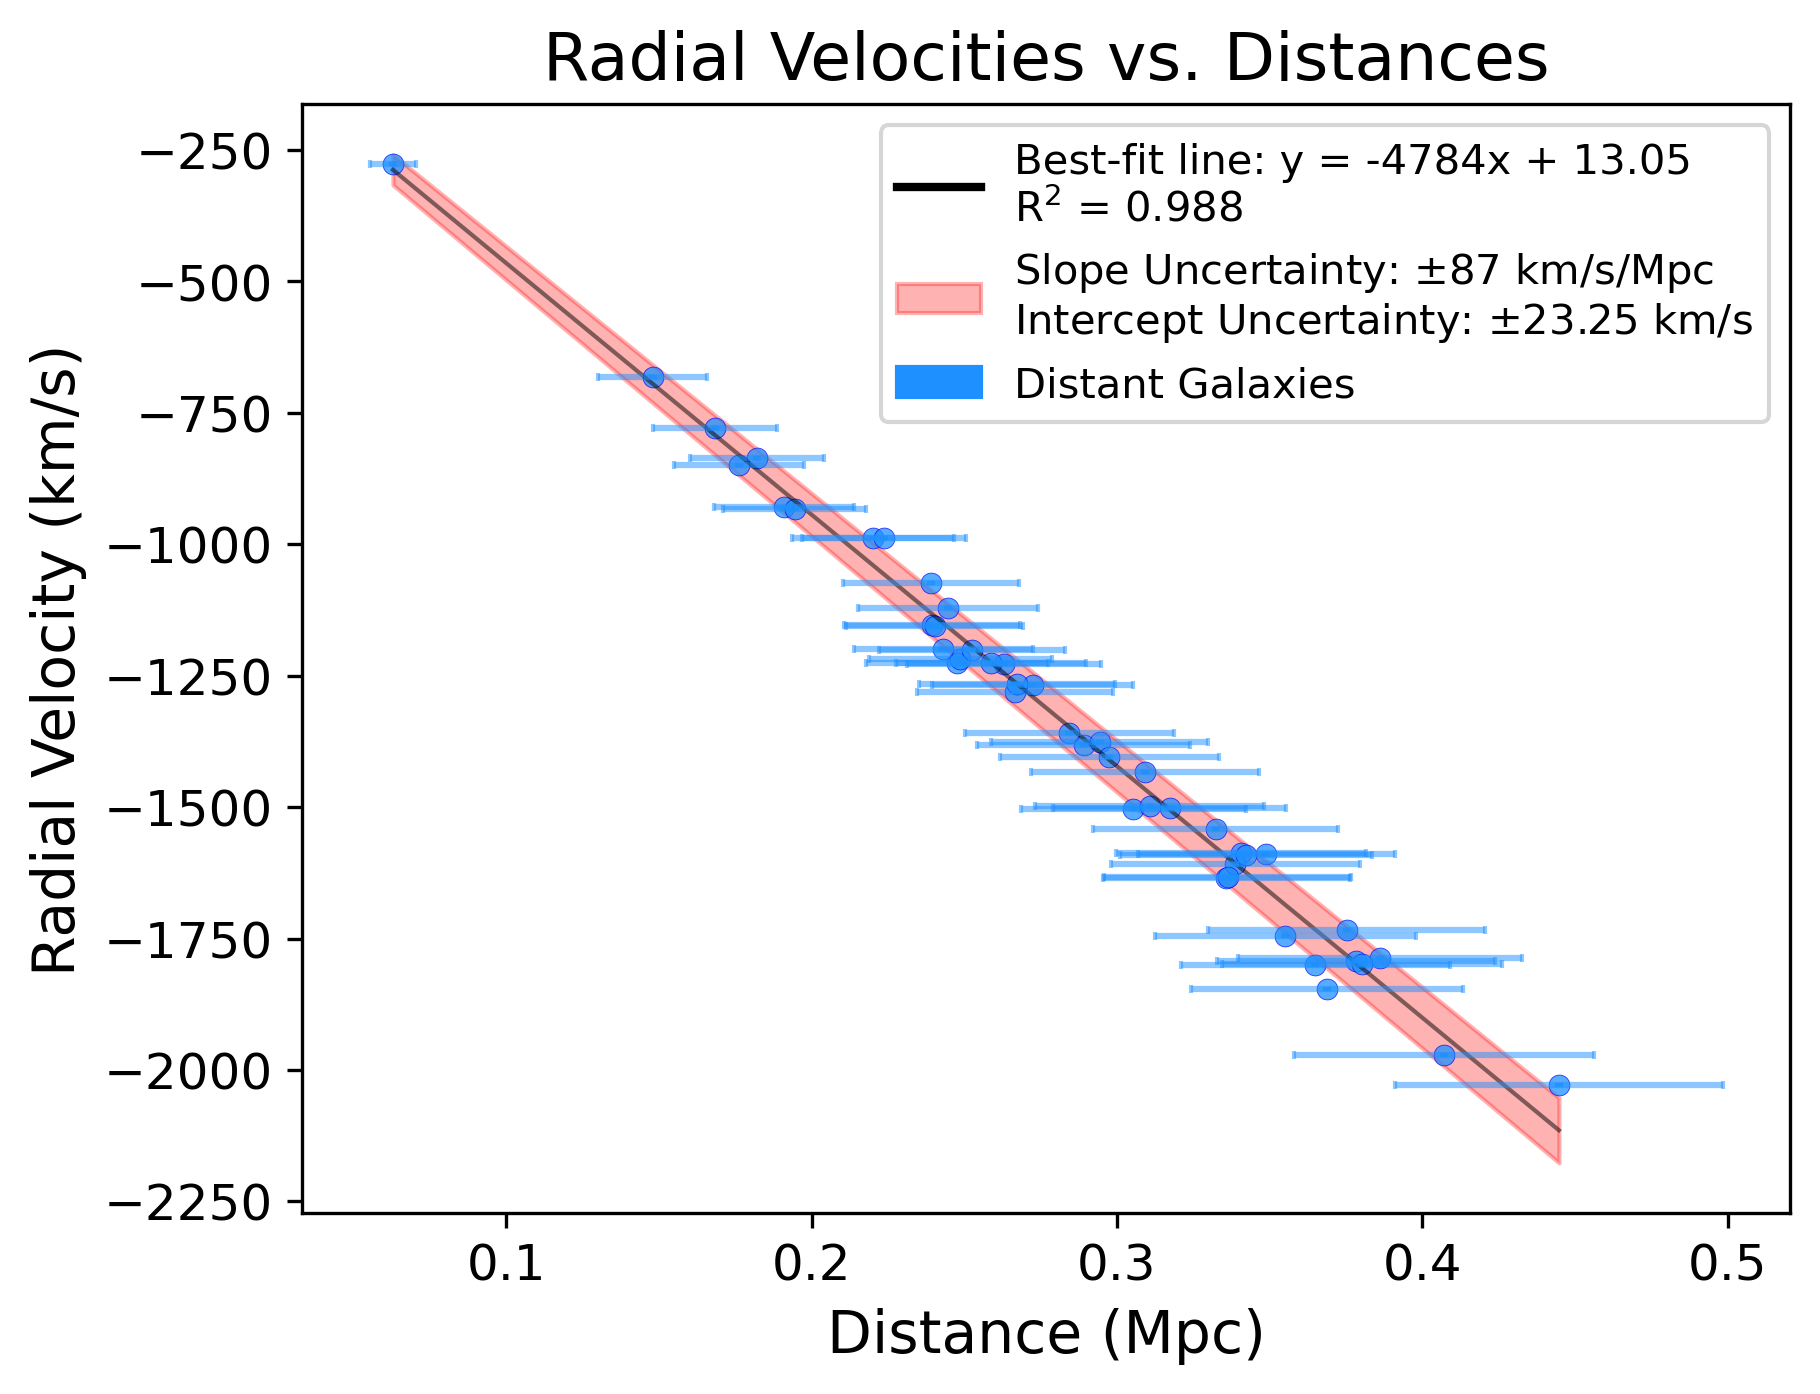

Hubble constant: -4784 +/- 87 km/s/Mpc


In [106]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Convert distances from parsecs to megaparsecs (Mpc)
distances_Mpc = [d/1e6 for d in distances]

# Set the number of Monte Carlo simulations
n_simulations = 1000

# Convert distances and radial velocities to numpy arrays
distances_Mpc_arr = np.array(distances_Mpc).reshape(-1, 1)
radial_velocities_arr = np.array(radial_velocities).reshape(-1, 1)

# Create empty lists to store the slope and intercept values from each simulation
slopes = []
intercepts = []

# Perform the Monte Carlo simulations
for i in range(n_simulations):
    # Resample the data with replacement
    sample_idx = np.random.choice(len(distances_Mpc), size=len(distances_Mpc), replace=True)
    sample_distances = distances_Mpc_arr[sample_idx]
    sample_radial_velocities = radial_velocities_arr[sample_idx]

    # Fit a linear regression model to the resampled data
    reg = LinearRegression().fit(sample_distances, sample_radial_velocities)
    slopes.append(reg.coef_[0][0])
    intercepts.append(reg.intercept_[0])

# Calculate the mean and standard deviation of the slope and intercept values
mean_slope = np.mean(slopes)
std_slope = np.std(slopes)
mean_intercept = np.mean(intercepts)
std_intercept = np.std(intercepts)
r2 = r2_score(radial_velocities, mean_slope * distances_Mpc_arr + mean_intercept)

# Angular positional uncertainty of the X-ray flashes
angular_uncertainty_degrees = 0.05  # degrees
angular_uncertainty_radians = np.radians(angular_uncertainty_degrees)

# Calculate the location uncertainty for each distance
loc_uncertainties = [distance * angular_uncertainty_radians for distance in distances]

# Add the location uncertainty to the existing distance uncertainties
total_distance_uncertainties = [d_uncertainty + loc_uncertainty for d_uncertainty, loc_uncertainty in zip(distance_uncertainties, loc_uncertainties)]

# Radial velocity uncertainty
radial_velocity_uncertainty = 0.1  # km/s

# Set plot parameters
plt.rcParams['figure.dpi'] = 300  # Increase DPI for better resolution
plt.rcParams['font.size'] = 12    # Increase font size for better readability
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

# Scatter plot of radial velocities against distances (Mpc)
fig, ax = plt.subplots()


# Best-fit line
x = np.linspace(min(distances_Mpc), max(distances_Mpc), 100)
y = mean_slope * x + mean_intercept
ax.plot(x, y, color='black', linewidth=1, alpha=0.5)

# Uncertainty band
y_upper = (mean_slope + std_slope) * x + (mean_intercept + std_intercept)
y_lower = (mean_slope - std_slope) * x + (mean_intercept - std_intercept)
ax.fill_between(x, y_lower, y_upper, color='red', alpha=0.3)

# Error bars for distance and radial velocity
ax.errorbar(distances_Mpc, radial_velocities, xerr=[d_uncertainty / 0.2e6 for d_uncertainty in distance_uncertainties], yerr=0.1, fmt=' ', capsize=1, color='dodgerblue', alpha=0.5)

ax.scatter(distances_Mpc, radial_velocities, color='dodgerblue',s=25, alpha=0.75, label='Distant Galaxies', edgecolors='blue', linewidths=0.2)
ax.set_xlabel("Distance (Mpc)")
ax.set_ylabel("Radial Velocity (km/s)")
ax.set_title("Radial Velocities vs. Distances")

# Legend
best_fit_line = mlines.Line2D([], [], color='black', linewidth=2, label=f'Best-fit line: y = {mean_slope:.0f}x + {mean_intercept:.2f}\nR$^2$ = {r2:.3f}')
uncertainty_band = mpatches.Patch(color='red', alpha=0.3, label=f'Slope Uncertainty: $\pm${std_slope:.0f} km/s/Mpc\nIntercept Uncertainty: $\pm${std_intercept:.2f} km/s')
distant_galaxies = mpatches.Patch(color='dodgerblue', label='Distant Galaxies')
ax.legend(handles=[best_fit_line, uncertainty_band, distant_galaxies], loc='upper right', fontsize=10)

plt.show()

# Print the Hubble constant and its uncertainty
print(f"Hubble constant: {mean_slope:.0f} +/- {std_slope:.0f} km/s/Mpc")


/var/folders/kv/ny8sb_xj09b1r7l0mtvkgjlm0000gn/T/ipykernel_67462/3800887459.py:14: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(xray_equat_coords, xray_polar_coords, c='red', marker='x', alpha=1, label='X-ray Flashes', s=90, edgecolors='black')


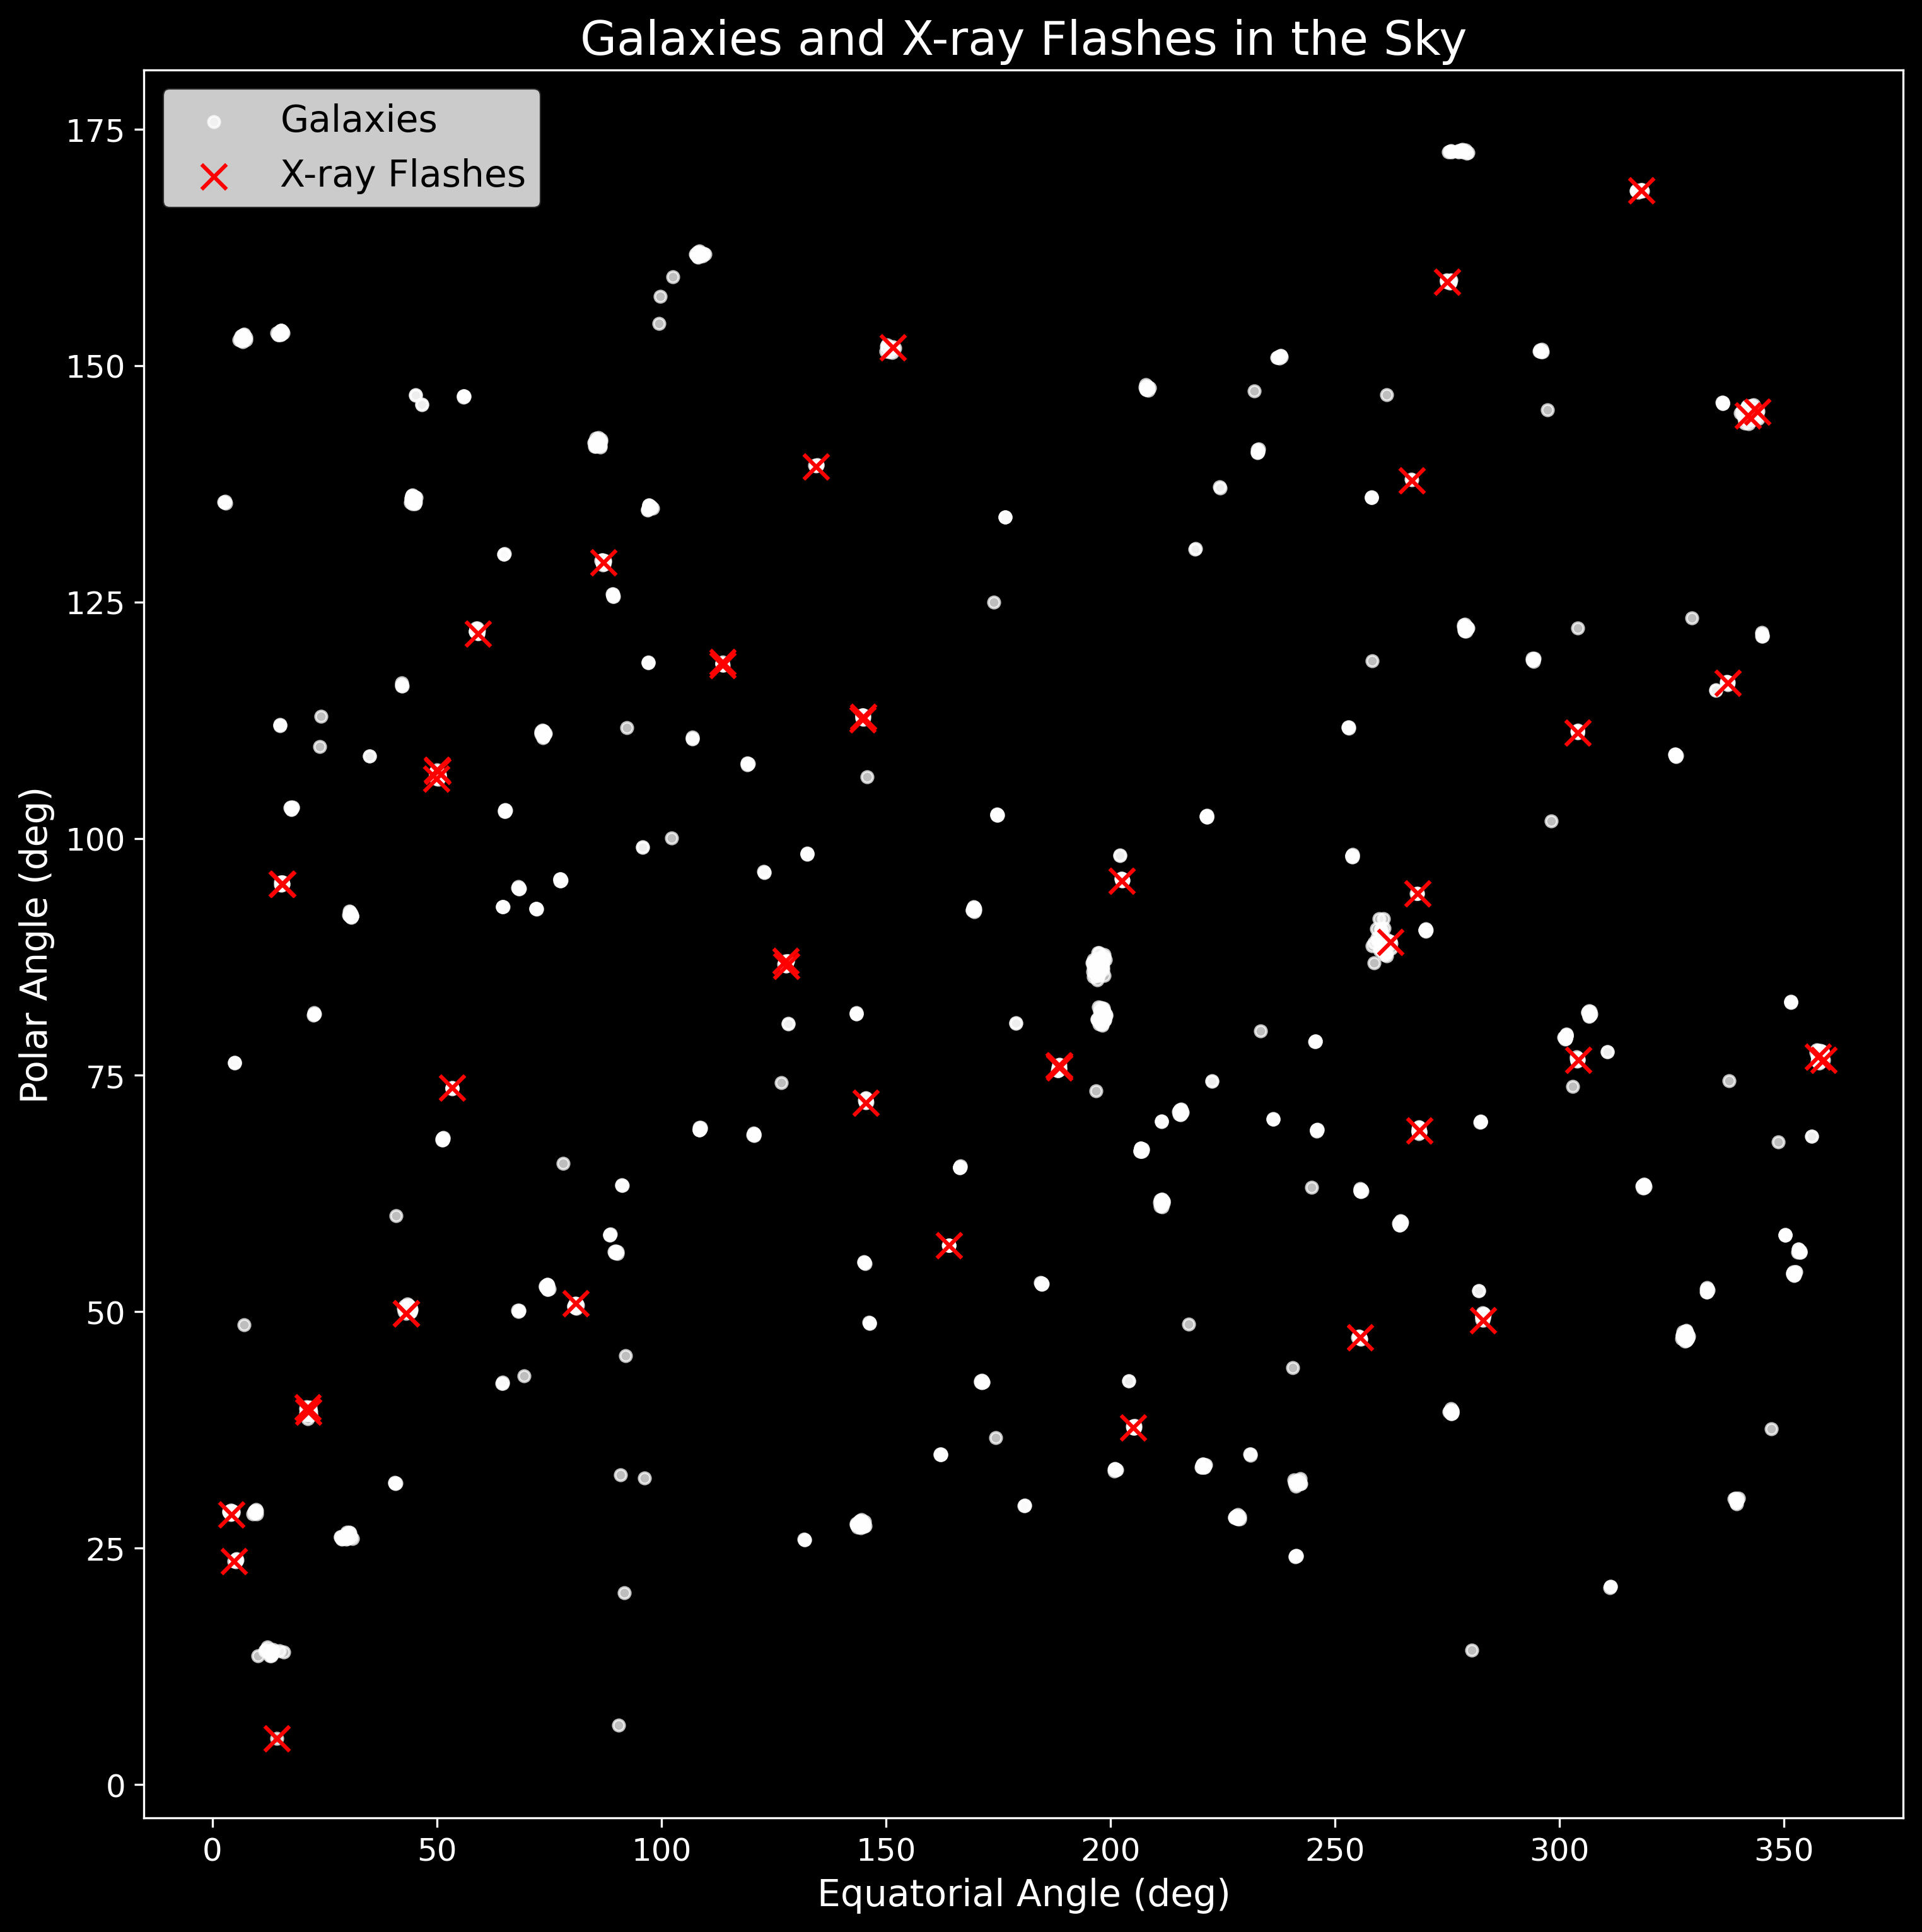

In [86]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Get coordinates
galaxy_polar_coords = galaxy_data['Polar'].values
galaxy_equat_coords = galaxy_data['Equat'].values
xray_polar_coords = [flash['Polar'] for flash, _ in xray_galaxy_matches]
xray_equat_coords = [flash['Equat'] for flash, _ in xray_galaxy_matches]

# Plot them (swap x and y data)
ax.scatter(galaxy_equat_coords, galaxy_polar_coords, c='white', marker='.', alpha=.75, label='Galaxies', s=75)
ax.scatter(xray_equat_coords, xray_polar_coords, c='red', marker='x', alpha=1, label='X-ray Flashes', s=90, edgecolors='black')

# Set the axis limits and labels (update labels)
ax.set_xlabel("Equatorial Angle (deg)", fontsize=14, color='white')
ax.set_ylabel("Polar Angle (deg)", fontsize=14, color='white')
ax.set_title("Galaxies and X-ray Flashes in the Sky", fontsize=18, color='white')

# Move the legend into the top left of the plot
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, loc='upper left', fontsize=14)

# Set the legend text color to black and background to solid white
for text in legend.get_texts():
    text.set_color("black")
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')

# Set the background color of the plot
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Set the tick colors and grid to white
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')

plt.show()


In [107]:
import pandas as pd

galaxy_data = pd.read_csv('/Users/kobibrown/Desktop/Distance_Ladder_Project/Clustered_Distant_Galaxies_With_Distances.csv')

max_distance = galaxy_data['Distance'].max()
max_distance_galaxy = galaxy_data.loc[galaxy_data['Distance'] == max_distance, 'Name'].values[0]

print(f"The galaxy with the maximum distance is {max_distance_galaxy} with a distance of {max_distance:.2f} Mpc.")


The galaxy with the maximum distance is BottomDG1453 with a distance of 446358.70 Mpc.
